In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the time series
def plot_time_series(df, numeric_data_columns, global_means, initial_means):
    for i, column in enumerate(numeric_data_columns, 1):
        plt.figure(figsize=(15, 5))
        
        # Plot individual points
        for key, grp in df.groupby('SampleID'):
            plt.scatter(grp['Time'], grp[column], alpha=0.5, color='C0')

        # Plot mean and confidence intervals
        mean_series = df.groupby('Time')[column].mean()
        ci = 1.96 * df.groupby('Time')[column].sem()
        plt.scatter(mean_series.index, mean_series, color='black', zorder=3, label='Time-Varying Mean')
        plt.fill_between(mean_series.index, mean_series - ci, mean_series + ci, color='gray', alpha=0.2)
        plt.fill_between(mean_series.index, mean_series - 2 * ci, mean_series + 2 * ci, color='gray', alpha=0.1)
        plt.axhline(y=global_means[column], color='red', linestyle='--', label='Global Mean')
        plt.axhline(y=initial_means[column], color='blue', linestyle=':', label='Initial Mean')
        plt.title(f'Time dynamics of {column}')
        plt.xlabel('Time')
        plt.ylabel(column)
        plt.legend()
        plt.tight_layout()
        #plt.savefig(f'figures/raw_dynamics/MICI_Mouse/{column}.png')
        plt.show()
        plt.close()

df = pd.read_excel('data/Murine Data.xlsx')
numeric_data_columns = df.select_dtypes(include=[np.number]).columns.drop(['Time', 'SampleID'])
global_means_all = df[numeric_data_columns].mean() # Calculate the global means for each numeric data column
initial_means_all = df[df['Time'] == df['Time'].min()][numeric_data_columns].mean() # Calculate the initial means for each numeric data column (at Time 0)

# Now plot the time series with the various models for each numeric data column
plot_time_series(df, numeric_data_columns, global_means_all, initial_means_all)

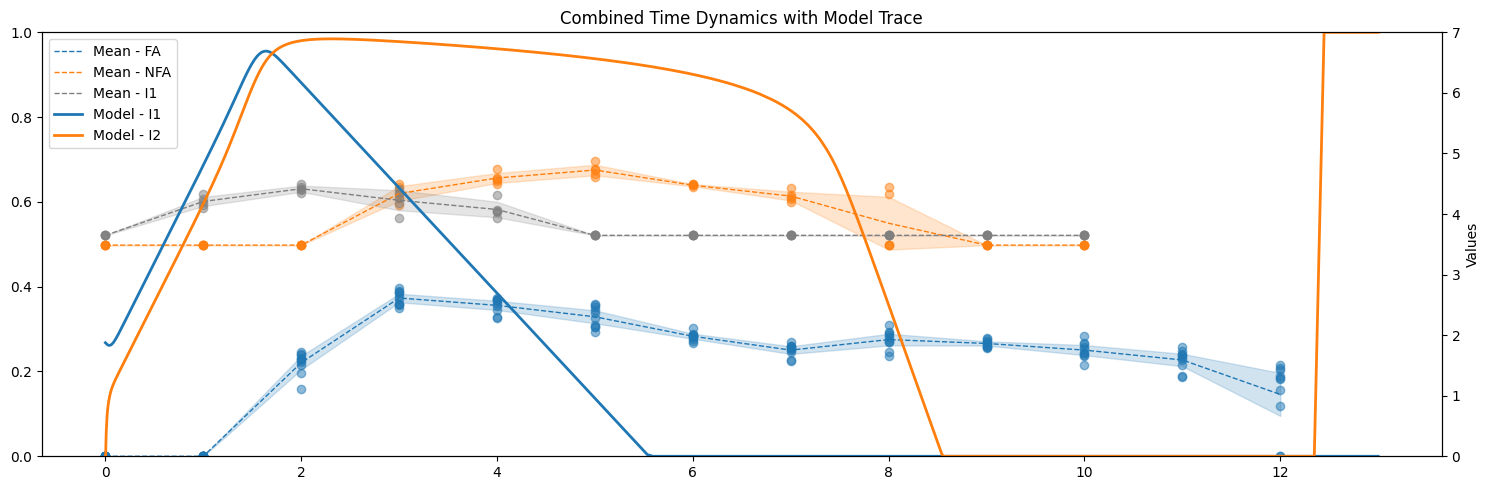

In [ ]:
# Load the solution from the CSV file
loaded_sol_df = pd.read_excel('data/Murine Data.xlsx', sheet_name='DD_sol', index_col=0)

def plot_combined_time_series(df, display_columns, models_results, global_means, initial_means, model_df):
    plt.figure(figsize=(15, 5))
    
    # Create a second y axis for the model trace
    ax2 = plt.gca().twinx()
    ax2.set_ylabel('Model Trace')
    ax2.set_yscale('linear')
    ax2.set_ylim(0, 7)
    ax2.set_ylabel('Model Values')
    
    # Set primary axis details
    ax = plt.gca()
    ax.set_xlabel('Time')
    ax.set_ylabel('Data Values')
    ax.set_yscale('linear')
    
    # Colors for the plots
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    
    for i, column in enumerate(display_columns):
        if column in df.columns:
            
            # Plot individual points
            for key, grp in df.groupby('SampleID'):
                ax.scatter(grp['Time'], grp[column], alpha=0.5, color=colors[i % len(colors)])

            # Plot mean and confidence intervals
            mean_series = df.groupby('Time')[column].mean()
            ci = 1.96 * df.groupby('Time')[column].sem()
            ax.plot(mean_series.index, mean_series, linestyle='--', linewidth=1, label=f'Mean - {column}', color=colors[i % len(colors)])
            ax.fill_between(mean_series.index, mean_series - ci, mean_series + ci, alpha=0.2, color=colors[i % len(colors)])

        # Plot model trace on second y axis
        if column in model_df.columns:
            ax2.plot(model_df.index, np.log10(model_df[column]), label=f'Model - {column}', linewidth=2, color=colors[(i + 3) % len(colors)]) # Offset the color index to differentiate the model

    plt.title('Combined Time Dynamics with Model Trace')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.tight_layout()
    plt.show()

display_columns = ['FA', 'NFA', 'DC1', 'DC2', 'DC3', 'EFA1', 'EFA2', 'I1', 'I2']  # replace with the columns you want to display
plot_combined_time_series(df, display_columns, global_means_all, initial_means_all, loaded_sol_df)

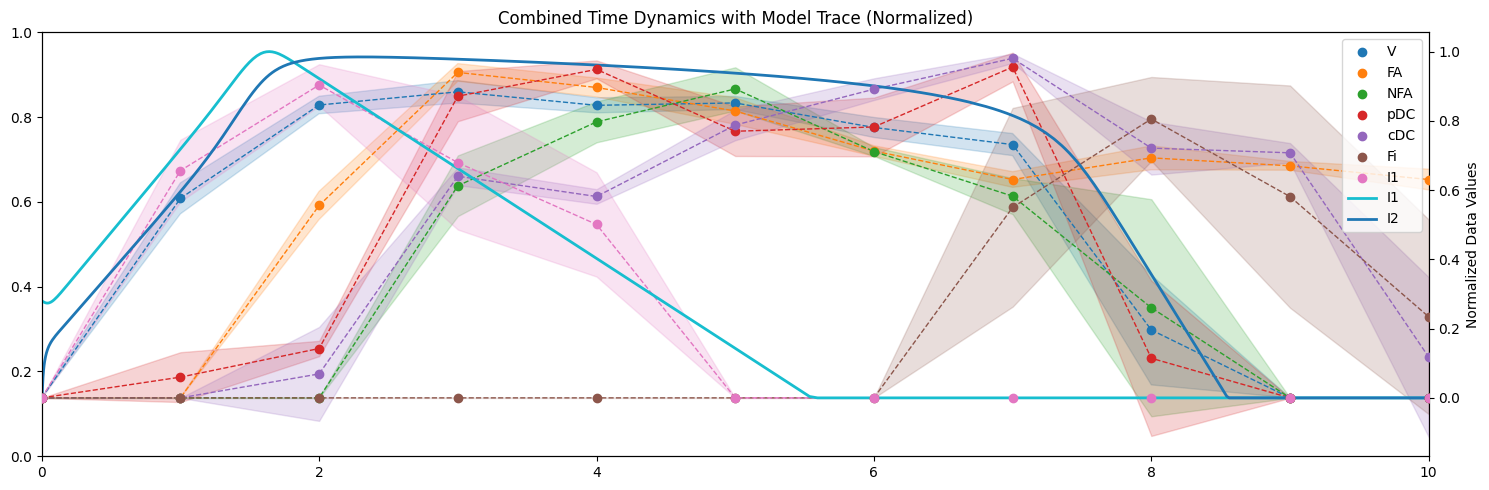

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the solution from the CSV file
loaded_sol_df = pd.read_excel('data/Murine Data.xlsx', sheet_name='DD_sol', index_col=0)

def plot_combined_time_series(df, display_columns, models_results, global_means, initial_means, model_df, labels, plot_individual=False):
    plt.figure(figsize=(15, 5))
    
    # Create a second y axis for the model trace
    ax2 = plt.gca().twinx()
    ax2.set_ylabel('Model Trace')
    
    # Set primary axis details
    ax = plt.gca()
    ax.set_xlabel('Time')
    ax.set_ylabel('Normalized Data Values')
    
    # Colors for the plots
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    
    for i, column in enumerate(display_columns):
        if column in df.columns:
            # Calculate the mean series
            mean_series = df.groupby('Time')[column].mean()

            # Adjust the data if the initial mean is greater than 1
            adjustment = initial_means[column] if initial_means[column] > 1 else 0
            
            # Adjusted data
            adjusted_data = df[column] - adjustment
            
            # Normalize the adjusted data
            normalized_mean_series = (mean_series - adjustment - adjusted_data.min()) / (adjusted_data.max() - adjusted_data.min())

            if plot_individual:
                # Plot individual points
                for key, grp in df.groupby('SampleID'):
                    normalized_grp_data = (grp[column] - adjustment - adjusted_data.min()) / (adjusted_data.max() - adjusted_data.min())
                    ax.scatter(grp['Time'], normalized_grp_data, alpha=0.5, color=colors[i % len(colors)])
            else:
                # Plot mean values as points
                ax.scatter(mean_series.index, normalized_mean_series, label=labels[i], color=colors[i % len(colors)], zorder=3)
                
            # Plot mean and confidence intervals with adjustment and normalization
            normalized_ci = 1.96 * (df.groupby('Time')[column].sem() / (adjusted_data.max() - adjusted_data.min()))
            ax.plot(mean_series.index, normalized_mean_series, linestyle='--', linewidth=1, color=colors[i % len(colors)])
            ax.fill_between(mean_series.index, normalized_mean_series - normalized_ci, normalized_mean_series + normalized_ci, alpha=0.2, color=colors[i % len(colors)])

        # Plot model trace on second y axis
        if column in model_df.columns and column != 'V':
            # Log transformation of model data to fit second y axis scale
            log_transformed_model_data = np.log10(model_df[column].replace(0, np.nan))  # Replace 0 with NaN to avoid log(0) error
            normalized_model_data = (log_transformed_model_data - log_transformed_model_data.min()) / (log_transformed_model_data.max() - log_transformed_model_data.min())
            ax2.plot(model_df.index, normalized_model_data, label=labels[i], linewidth=2, color=colors[(i + 3) % len(colors)]) # Offset the color index to differentiate the model

    plt.title('Combined Time Dynamics with Model Trace (Normalized)')
    ax.legend(loc='upper left')
    # Set x axis limits
    ax.set_xlim(0, 10)
    ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

display_columns = ['V', 'FA', 'NFA', 'pDC', 'cDC', 'Fi', 'I1', 'I2']  # replace with the columns you want to display
labels = ['V', 'FA', 'NFA', 'pDC', 'cDC', 'Fi', 'I1', 'I2']
plot_combined_time_series(df, display_columns, models_results, global_means_all, initial_means_all, loaded_sol_df, labels, plot_individual=False)